In [1]:
from LABNET import Neuron, Net

In [2]:
dl_big = [
    ['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i'] #0-7 for inputs
    
    ,['fc',[0,1,2]]
    ,['fc',[-2,3,-4]]
    ,['fc',[3,4,5]]
    ,['fc',[3,5,7]]
    ,['fc',[0,7]] #8 - 12 for this layer
    
    ,['fc',[8,10]]
    ,['fc',[9,-11]]
    ,['fc',[12]]
    ,['fc',[-8,-9]] #13 - 16
    
    
    
    ,['o',[-13,14]]
    ,['o',[-14,15,-16]]
    ,['o',[-15,-16]]
    ,['o',[-13,16]]
    
]

In [3]:
nn_big = Net(dl_big)
nn_big.generate_inputs()
nn_big.generate_outputs()
nn_big.tensorize()

self.inputs and self.outputs are now tensors of shape torch.Size([256, 8]) and torch.Size([256, 4]) respectively!


In [4]:
nn_big.outputs

tensor([[False,  True, False, False],
        [False, False,  True, False],
        [False,  True, False, False],
        ...,
        [False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True]])

In [5]:
nn_big.percent_true()

[tensor(0.0938), tensor(0.0781), tensor(0.1562), tensor(0.7500)]

In [6]:
nn_big.input_size

8

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = nn.Linear(nn_big.input_size, 5) ##make these all variables duh
        self.hidden_2 = nn.Linear(5,4)
        self.output = nn.Linear(4, nn_big.output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden_1(x))
        x = self.relu(self.hidden_2(x))
        x = self.output(x)
        return x

In [9]:
model = MyModel()

In [10]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [11]:
input_data = nn_big.inputs.float()
output_data = nn_big.outputs.float()

In [12]:
input_data.dtype

torch.float32

In [13]:
# Training loop
num_epochs = 5
hidden_layer_weights = torch.zeros(num_epochs, 5, 8) #this should be num epochs by hidden size.  
for epoch in range(num_epochs):
    # Forward pass
    output = model(input_data)
    ###this needs to be stochastic
    # Compute the loss
    loss = criterion(output, output_data)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss.item()

    print(model.hidden_1.weight.shape) ##i also have biases here.  are those interesting??
    hidden_layer_weights[epoch] = model.hidden_1.weight
    print(model.hidden_2.weight)
    print(model.output.weight)

# After training, you can use the model to make predictions
test_input = torch.randn(1, 8)  # Single test input with 8 values
predicted_output = model(test_input)
print("Predicted output:", predicted_output)

torch.Size([5, 8])
Parameter containing:
tensor([[ 0.1141, -0.1947,  0.1246,  0.0684,  0.0087],
        [-0.2305, -0.3241, -0.1818,  0.1559, -0.3062],
        [-0.1672, -0.2360,  0.3415,  0.3244, -0.3826],
        [-0.2297,  0.1663,  0.0406, -0.0950,  0.2558]], requires_grad=True)
Parameter containing:
tensor([[-0.1207,  0.4859,  0.0225, -0.1851],
        [ 0.1705,  0.4376,  0.2679, -0.1683],
        [-0.0598, -0.0629,  0.2283, -0.0211],
        [-0.2943,  0.0407, -0.3368,  0.0728]], requires_grad=True)
torch.Size([5, 8])
Parameter containing:
tensor([[ 0.1141, -0.1947,  0.1246,  0.0684,  0.0087],
        [-0.2305, -0.3241, -0.1818,  0.1559, -0.3062],
        [-0.1673, -0.2361,  0.3415,  0.3240, -0.3826],
        [-0.2297,  0.1663,  0.0406, -0.0950,  0.2558]], requires_grad=True)
Parameter containing:
tensor([[-0.1207,  0.4859,  0.0232, -0.1851],
        [ 0.1705,  0.4376,  0.2677, -0.1683],
        [-0.0598, -0.0629,  0.2276, -0.0211],
        [-0.2943,  0.0407, -0.3360,  0.0728]], re

In [14]:
hidden_layer_weights.shape

torch.Size([5, 5, 8])

[[-0.2346521  -0.23899454 -0.19367206  0.22560698  0.07546984 -0.29005793
   0.19202636 -0.34082767  0.18313816 -0.01186966 -0.26683906 -0.33500332
  -0.16575256  0.21614702  0.08472677 -0.1664078   0.25541103  0.26865444
  -0.16449672  0.32848072 -0.19881068 -0.23527788  0.01194374 -0.1142915
  -0.29871374  0.22852397 -0.18761806  0.3335854   0.2786909   0.33212832
   0.20704888  0.10523786 -0.32827404  0.05168547 -0.15760228 -0.28435093
  -0.29574457 -0.2238214   0.1824208   0.17712435]
 [-0.23464306 -0.23898457 -0.193655    0.22563429  0.07550379 -0.2900491
   0.19205795 -0.34082416  0.18317112 -0.01184766 -0.26683724 -0.33500466
  -0.16573744  0.21618766  0.08475594 -0.16639313  0.2553495   0.26858538
  -0.1645222   0.32842183 -0.19887534 -0.2352966   0.01189018 -0.11432575
  -0.29879558  0.2283666  -0.18775702  0.3334317   0.2784457   0.33193913
   0.20686594  0.10507103 -0.32826826  0.05172531 -0.15757638 -0.28435022
  -0.29573852 -0.22380327  0.1824703   0.17717385]
 [-0.2346341

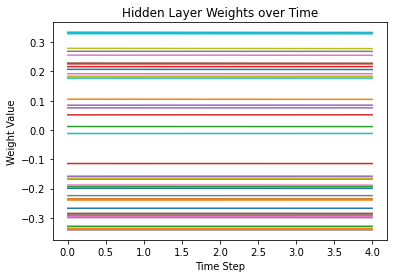

In [16]:
import matplotlib.pyplot as plt
import numpy as np
weights = hidden_layer_weights.detach().numpy()

shapes = weights.shape
weights = np.reshape(weights,(shapes[0],shapes[1]*shapes[2]))
#print(weights)
# Get the number of time steps and dimensions
num_time_steps, num_dimensions = weights.shape
print(num_time_steps,num_dimensions)
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the lines for each dimension
for i in range(num_dimensions):
    ax.plot(range(num_time_steps), weights[:, i], label=f"Dimension {i+1}")

# Set the labels and title
ax.set_xlabel('Time Step')
ax.set_ylabel('Weight Value')
ax.set_title('Hidden Layer Weights over Time')

# Add a legend how bout not
#ax.legend()

# Show the plot
plt.show()

##these look correct, just, it isn't stochastic.  its doing the full batch of all data at every iteration, its probably exactly right after like, 5 -10 samples.  
